In [1]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import time
import simpy
from scipy.stats import skew 
from IPython.display import
import warnings
warnings.filterwarnings('ignore')

**Hints for students:** The utility section contains code you need to use *unchanged* to generate the test data required. You may use this code for your final solution, beware not to overwrite function definitions in this section. Otherwise you can ignore the code in this section.

# Utilities

## Points and Distances

Euclidean Distance between two points

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

The nearest link between two point sets

In [3]:
def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP         

## Graphs

In [4]:
def generateRandomGraph(n, x0, y0, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    x0 = rounding(x0)
    y0 = rounding(y0)
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [5]:
def plotGraph(P, E, col='b', grid=False):
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()

Split a graph into not connected subgraphs, if any.

In [6]:
def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ] 
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E       

In [7]:
def generateGraph(n, x0, y0, r):
    P, E = generateRandomGraph(n, x0, y0, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

Graph for seed 7000 has 200 vertices and 270 edges


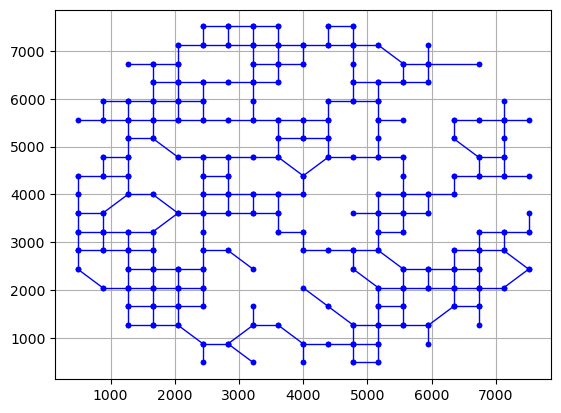

Graph for seed 7001 has 200 vertices and 283 edges


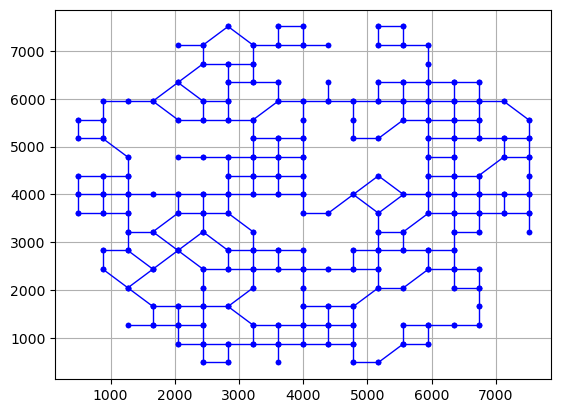

Graph for seed 7002 has 200 vertices and 285 edges


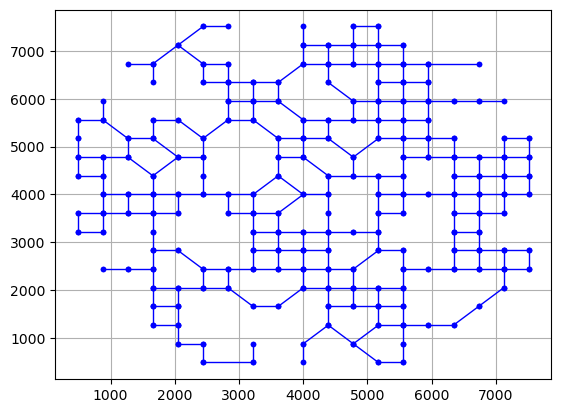

Graph for seed 7003 has 200 vertices and 287 edges


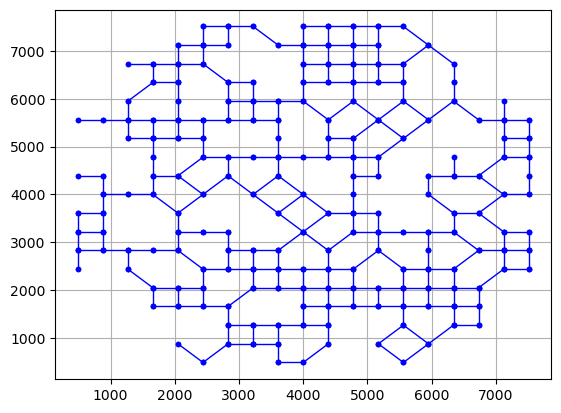

Graph for seed 7004 has 200 vertices and 278 edges


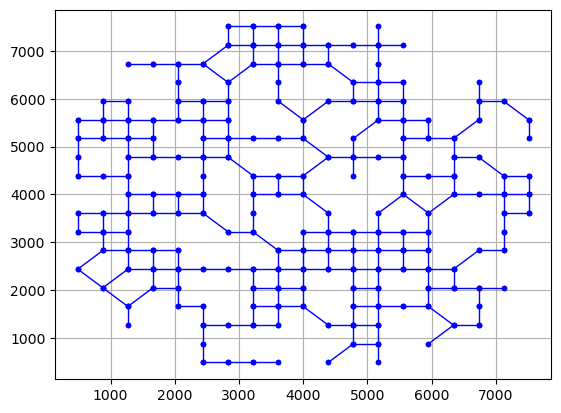

In [8]:
for i in range(7000, 7005):
    random.seed(i)
    P, E = generateGraph(200, 4000, 4000, 4000)
    print("Graph for seed", i, "has", len(P), "vertices and", len(E), "edges")
    plotGraph(P, E,grid=True)
    plt.show()

## Lists and Paths

In [9]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [10]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [11]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [12]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

## Generate Customer Locations

In [13]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [14]:
def generateRandomTargets(V, E, n=5):
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 300
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [15]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Generate Warehouse Locations

In [16]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

## Plot Map with Delivery Route

In [17]:
def plotMap(G, T=[], P=[], W=None, mW= [], costs=[],
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False, together = False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        minX = min([p[0] for p in V])
        plt.text(minX, 4, text)
    if together and mW is not None:
        for i, w in enumerate(mW):
            label = f'Warehouse {i}: €{costs[i]}' if i < len(costs) else f'Warehouse {i}'
            plt.plot( [ w[0] ], [ w[1] ], 
                  styleW, ms=msW)
            plt.text(w[0], w[1], label, fontsize=11, verticalalignment='bottom')  # Adjust label position
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    if grid:
        plt.grid()
    plt.show()

## Generate Data

In [18]:
def generateData(seed=None, nodes=130, customers=180, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        # print("  W ∈ V  is the location of the distribution warehouse")
        # print("    given as a pair (x, y) of integer coordinates")
        # print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    V, E = generateGraph(nodes, 4000, 4000, 4000)
    
    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)
    
    return (V, E), C

Data Generation is reproducible

In [19]:
D1 = generateData(1234)
D2 = generateData(1234)
D1 == D2

True

# Generate Data

This section demonstrates how you can generate the test data for the problem.

## General Help Message

If you use `generateData()` without any parameters you will get a general help message.

In [20]:
M, C = generateData()

Usage:  M, C = generateData(seed=None, 
                            nodes=100, customers=50, 
                            plot=False, log=False)

  seed  the seed value to be used for data generation. 
        To test the application use seed=0, it will create
        a small map, with a very few customer locations and
        a small set of delivery data.

  nodes the number of intersections (vertices) in the generated map

  customers  the number of customers generated on the map

  log   Controls print output during data generation.

  plot  Controls graphical output during data generation.

Returns:

  M = (V, E) is the generated map given as a graph
    where V is a list of vertices, with each vertice 
    given as a pair (x, y) of integer coordinates, 
    and E is a list of edges, with each edge given
    as a pair (A, B) of vertices, with each vertex again
    given as a pair (x, y) of integer coordinates

  C is a list of customer locations
    given as pairs (x, y) of integer

## Analysing Simple Test Data

This section illustrates the data structure generated.

Generated map with 130 nodes and 180 customer locations


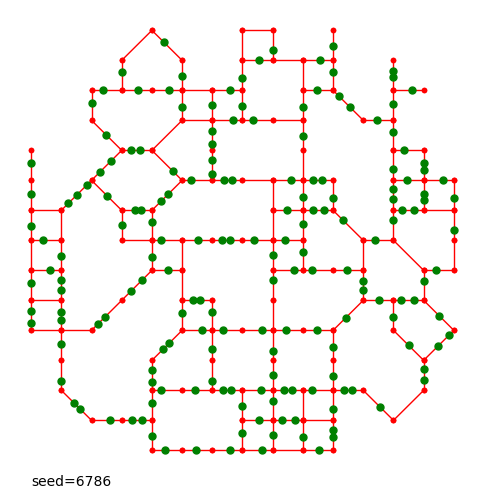

In [21]:
Di = generateData(seed=6786, log=True, plot=True)

In [22]:
import pickle
with open('23106786_1.pickled', 'wb') as f:
    pickle.dump(Di, f)#use different name 

In [23]:
M, C = Di

### The Graph

You can identify the points in the grid above. The vertices of the graph are:

In [24]:
V, E = M
V

[(570, 2530),
 (570, 3020),
 (570, 3510),
 (570, 4000),
 (570, 4490),
 (570, 4980),
 (570, 5470),
 (1060, 1550),
 (1060, 2040),
 (1060, 2530),
 (1060, 3020),
 (1060, 3510),
 (1060, 4000),
 (1060, 4490),
 (1550, 1060),
 (1550, 2530),
 (1550, 4980),
 (1550, 5960),
 (1550, 6450),
 (2040, 1060),
 (2040, 3020),
 (2040, 4000),
 (2040, 4490),
 (2040, 5470),
 (2040, 6450),
 (2040, 6940),
 (2530, 570),
 (2530, 1060),
 (2530, 1550),
 (2530, 2040),
 (2530, 3510),
 (2530, 4000),
 (2530, 4490),
 (2530, 5470),
 (2530, 6450),
 (2530, 7430),
 (3020, 570),
 (3020, 1550),
 (3020, 2530),
 (3020, 3020),
 (3020, 3510),
 (3020, 4000),
 (3020, 4980),
 (3020, 5960),
 (3020, 6450),
 (3020, 6940),
 (3510, 570),
 (3510, 1550),
 (3510, 2040),
 (3510, 2530),
 (3510, 3020),
 (3510, 4000),
 (3510, 4980),
 (3510, 5470),
 (3510, 5960),
 (3510, 6450),
 (4000, 570),
 (4000, 1060),
 (4000, 1550),
 (4000, 2530),
 (4000, 4000),
 (4000, 4980),
 (4000, 5960),
 (4000, 6450),
 (4000, 6940),
 (4000, 7430),
 (4490, 570),
 (4490,

The edges of the graph are:

In [25]:
E

[((570, 2530), (570, 3020)),
 ((570, 2530), (1060, 2530)),
 ((570, 3020), (1060, 3020)),
 ((570, 3510), (570, 3020)),
 ((570, 3510), (1060, 3510)),
 ((570, 4000), (570, 3510)),
 ((570, 4000), (570, 4490)),
 ((570, 4980), (570, 4490)),
 ((570, 5470), (570, 4980)),
 ((1060, 2040), (1060, 1550)),
 ((1060, 2040), (1060, 2530)),
 ((1060, 2530), (1060, 3020)),
 ((1060, 3510), (1060, 3020)),
 ((1060, 4000), (570, 4000)),
 ((1060, 4000), (1060, 3510)),
 ((1060, 4000), (1060, 4490)),
 ((1060, 4490), (570, 4490)),
 ((1060, 4490), (1550, 4980)),
 ((1550, 1060), (1060, 1550)),
 ((1550, 1060), (2040, 1060)),
 ((1550, 2530), (1060, 2530)),
 ((1550, 6450), (1550, 5960)),
 ((1550, 6450), (2040, 6450)),
 ((2040, 3020), (1550, 2530)),
 ((2040, 3020), (2530, 3510)),
 ((2040, 4000), (2040, 4490)),
 ((2040, 4000), (2530, 4000)),
 ((2040, 4490), (1550, 4980)),
 ((2040, 4490), (2530, 4490)),
 ((2040, 5470), (1550, 4980)),
 ((2040, 5470), (1550, 5960)),
 ((2040, 5470), (2530, 5470)),
 ((2040, 6450), (2530, 64

### Customer Addresses

The customer addresses (green dots in the map) are:

In [26]:
C

[(570, 2648),
 (570, 2843),
 (570, 3309),
 (570, 4242),
 (570, 4765),
 (570, 5259),
 (761, 4000),
 (869, 3510),
 (1060, 1709),
 (1060, 2304),
 (1060, 2698),
 (1060, 2835),
 (1060, 3193),
 (1060, 3346),
 (1060, 3743),
 (1175, 4605),
 (1266, 1342),
 (1318, 4748),
 (1356, 1253),
 (1473, 4903),
 (1550, 6249),
 (1657, 2637),
 (1680, 5110),
 (1732, 6450),
 (1774, 2754),
 (1783, 5726),
 (1804, 4725),
 (1843, 1060),
 (1869, 5299),
 (2040, 4252),
 (2040, 6745),
 (2191, 3171),
 (2196, 5470),
 (2210, 1060),
 (2256, 4490),
 (2299, 6450),
 (2343, 5470),
 (2352, 4490),
 (2366, 1060),
 (2376, 3356),
 (2530, 798),
 (2530, 1343),
 (2530, 1694),
 (2530, 1880),
 (2530, 3730),
 (2530, 4296),
 (2678, 4638),
 (2682, 1550),
 (2682, 4000),
 (2712, 2222),
 (2725, 7234),
 (2736, 570),
 (2795, 4755),
 (2796, 3510),
 (2804, 6450),
 (2811, 2321),
 (2871, 5128),
 (3020, 2813),
 (3020, 6185),
 (3020, 6685),
 (3171, 4980),
 (3194, 3020),
 (3225, 1550),
 (3245, 570),
 (3270, 4000),
 (3315, 3020),
 (3346, 2530),
 (3510

### The Warehouse Address

Warehouses should be located on or near an intersection on the map.
To generate a warehouse address use:

In [27]:
W = generateWarehouseLocation(M)

In [28]:
W

(4980, 1060)

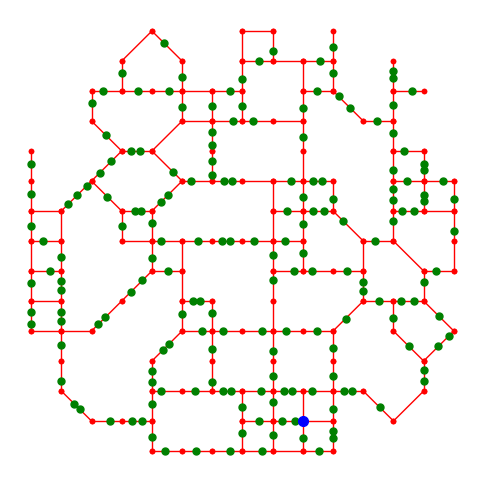

In [29]:
plotMap((V, E), T=C, W=W)

## Real Sample Data

This section shows sample data as you you may get them for your required simulation. 

Generated map with 130 nodes and 180 customer locations


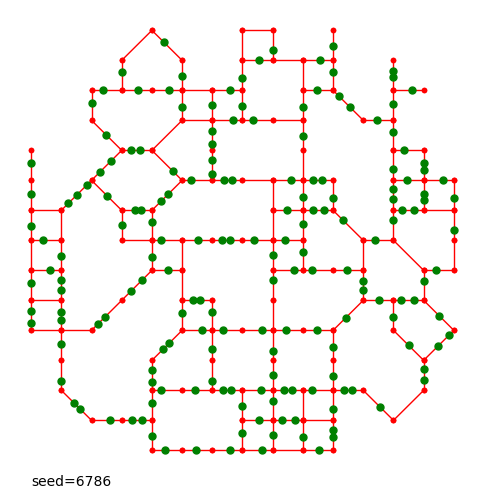

In [30]:
data = generateData(6786, plot=True, log=True)

Save sample data as pickle file:

In [31]:
import pickle
with open('23106786_main.pickled', 'wb') as f:
    pickle.dump(data, f)   # Call the main file

# Loading the data


In [32]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np

In [33]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

# Targets


In [34]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

# Warehouse locations

In [35]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

In [36]:
ware1 = []
for i in range(20):
    random.seed(i)
    W = generateWarehouseLocation(M)
    if W not in ware1:
        ware1.append(W)
print(len(ware1))
print(ware1)

19
[(5470, 4980), (2530, 6450), (1550, 1060), (4000, 4000), (4000, 7430), (2040, 3020), (4980, 2530), (4000, 1550), (6940, 2040), (1060, 2040), (6450, 6450), (6940, 4490), (4490, 570), (2530, 1060), (3510, 5470), (5470, 1060), (5960, 5960), (3510, 570), (1060, 3510)]


# Load sample data

In [37]:
import pickle
with open('23106786_1.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [38]:
# Split the map into Vertices and Edges:
V, E = M

In [39]:
#Pick a random location for the Warehouse at one of the intersections (vertices) on the map.
W = generateWarehouseLocation(M)

In [40]:
V

[(570, 2530),
 (570, 3020),
 (570, 3510),
 (570, 4000),
 (570, 4490),
 (570, 4980),
 (570, 5470),
 (1060, 1550),
 (1060, 2040),
 (1060, 2530),
 (1060, 3020),
 (1060, 3510),
 (1060, 4000),
 (1060, 4490),
 (1550, 1060),
 (1550, 2530),
 (1550, 4980),
 (1550, 5960),
 (1550, 6450),
 (2040, 1060),
 (2040, 3020),
 (2040, 4000),
 (2040, 4490),
 (2040, 5470),
 (2040, 6450),
 (2040, 6940),
 (2530, 570),
 (2530, 1060),
 (2530, 1550),
 (2530, 2040),
 (2530, 3510),
 (2530, 4000),
 (2530, 4490),
 (2530, 5470),
 (2530, 6450),
 (2530, 7430),
 (3020, 570),
 (3020, 1550),
 (3020, 2530),
 (3020, 3020),
 (3020, 3510),
 (3020, 4000),
 (3020, 4980),
 (3020, 5960),
 (3020, 6450),
 (3020, 6940),
 (3510, 570),
 (3510, 1550),
 (3510, 2040),
 (3510, 2530),
 (3510, 3020),
 (3510, 4000),
 (3510, 4980),
 (3510, 5470),
 (3510, 5960),
 (3510, 6450),
 (4000, 570),
 (4000, 1060),
 (4000, 1550),
 (4000, 2530),
 (4000, 4000),
 (4000, 4980),
 (4000, 5960),
 (4000, 6450),
 (4000, 6940),
 (4000, 7430),
 (4490, 570),
 (4490,

In [41]:
W = (5470, 2530)#,(570, 5470),(6940, 6450),(4980, 4490),(3020, 3510)

In [42]:
print(W)

(5470, 2530)


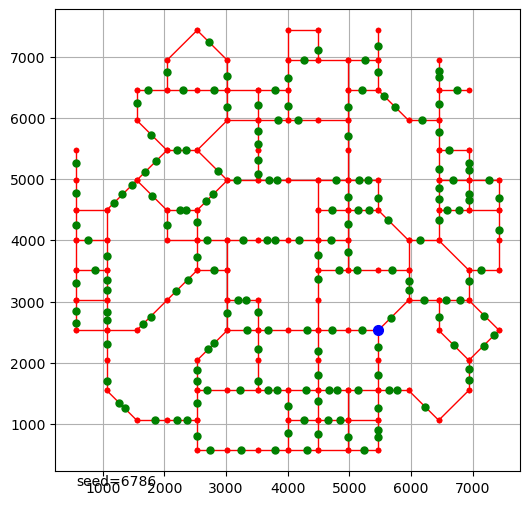

In [43]:
plotMap(M, T=C, P=[], W=W, text="seed=6786", grid=True)

In [44]:
#Generating Delivery Data
def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=C*p, size=days)
    D = [ sorted(list(np.random.choice(range(C), size=i))) for i in R ]
    return D

In [45]:
#Delivery over one month for Sample Map
D = generateDeliveryData(0.23, len(C), 30)

In [46]:
sum([len(i) for i in D])

1255

In [47]:
#Finding the shortest path
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [48]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

In [49]:
#Testing
A = C[0]
B = C[-1]

In [50]:
MAB = addTargets(M, [A, B])

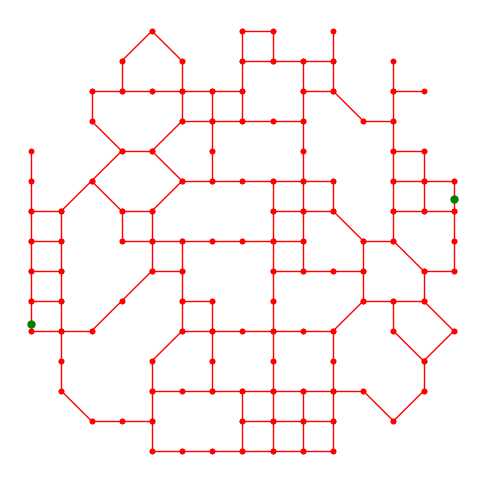

In [51]:
plotMap(MAB, T=[A, B])

In [52]:
P = shortestPath(MAB, A, B)

In [53]:
P

[(570, 2648),
 (570, 2530),
 (1060, 2530),
 (1550, 2530),
 (2040, 3020),
 (2530, 3510),
 (3020, 3510),
 (3020, 4000),
 (3510, 4000),
 (4000, 4000),
 (4490, 4000),
 (4980, 4000),
 (4980, 4490),
 (5470, 4490),
 (5960, 4000),
 (6450, 4000),
 (6450, 4490),
 (6940, 4490),
 (7430, 4490),
 (7430, 4693)]

In [54]:
pathLength(P)

9257

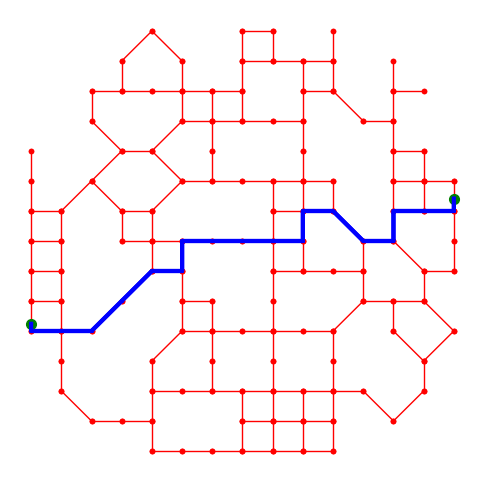

In [55]:
plotMap(MAB, T=[A, B], P=P)

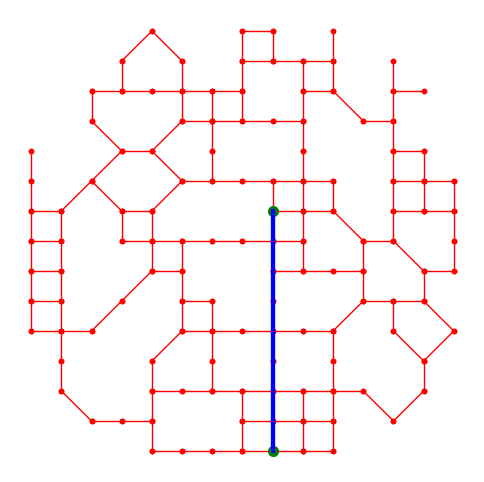

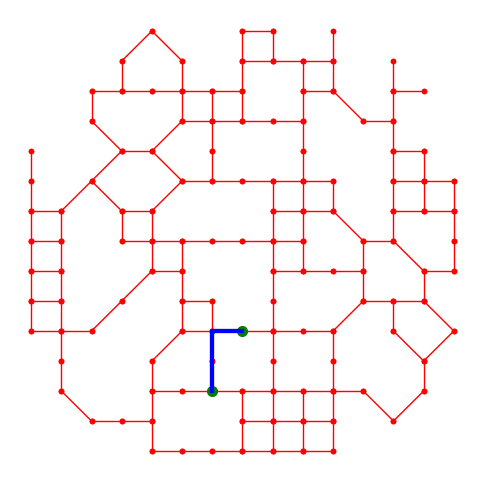

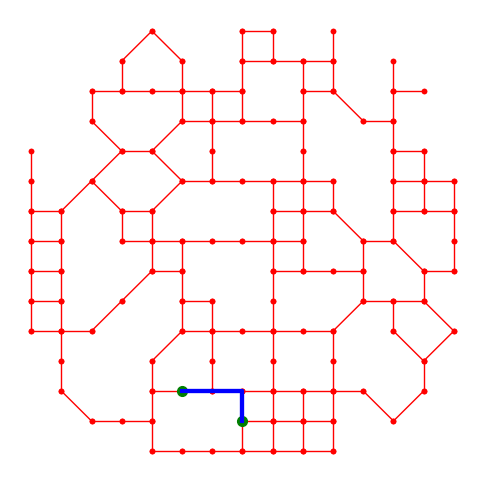

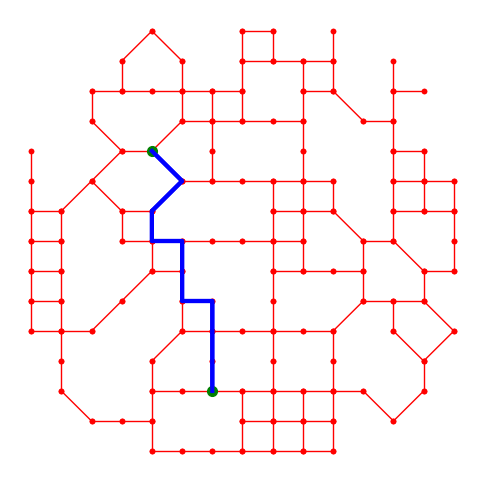

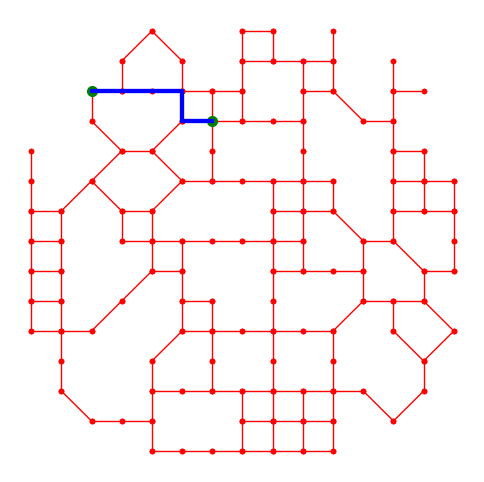

In [56]:
#IS this steps correct ask professor 
random.seed(13)
V, E = M
for i in range(5):
    [A, B] = random.sample(V, k=2)
    MAB = addTargets(M, [A, B])
    P = shortestPath(MAB, A, B)
    plotMap(MAB, T=[A, B], P=P)

# Time


In [57]:
#Utilities (as before)
#Points and Distances¶ Step 7

In [58]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

# Targets

In [59]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

In [60]:
#Generate Warehouse Location

In [61]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

# Time Handling
Convention: In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

timestamp(t) generates a timestamp string in the form [dd] hh:mm:ss.d

In [62]:
    def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(math.floor(t))
        t = int(math.floor((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [63]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.0'

In [64]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [65]:
def day(now):
    return int(now//(24*3600))

# Plotting Routines

In [66]:
import scipy.stats as stats

def histplot(data, title="", xlabel="",
             width=None, height=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()
        
    hist=plt.hist(data, density=True)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
        
    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy, 
            f'μ={μ:2.2f}\nσ={σ:2.2f}', 
            ha='right', va='top', 
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [67]:
def dailyPlot(data, 
              title="", ylabel="",
              width=None, height=None):
    
    days = len(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)
    
    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    
    ms = 2 if len(data)>100 else 5
    lw = 0.5 if len(data)>100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)
    
    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')
    
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Finding Shortest Path

In [68]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [69]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [70]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# Finding Shortest Delivery Route 
Iterative Integer Programming

In [71]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [72]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [73]:
import time

def createLoop(M, T, timing=False):
    
    if timing:
        start_time = time.time()
        last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)

    if n==1:
        return T
        
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()

    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
        prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
        
    trip = trips[0]
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

In [74]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

# Heuristic Algorithm

In [75]:
def createLoopH(M, T, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()
        last_time = time.time()
        
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopH:    {time.time()-start_time:6.2f}s")

    return makeLoop(L)

# Class Recorder
We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder

In [76]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot
        
        self.timing = timing
        self.start_time = time.time()
        self.last_time = self.start_time
        self.cum_timer = {}

        Customer.REGISTER = []
        Parcel.REGISTER = []

        # create a data frame for records per working day
        self.daily = pd.DataFrame()
        self.daily['begin work at'] = [None]*days
        self.daily['end work at'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days

    def timer(self, s):
        t = time.time()
        Δt = t-self.last_time
        if self.timing:
            print(f"==== t: {t-self.start_time:6.2f}s "
                  f"Δt: {Δt:6.2f}s [{s:s}]")
        if s in self.cum_timer:
            self.cum_timer[s] += Δt
        else:
            self.cum_timer[s] = Δt
        self.last_time = t
    
    def totalTime(self):
        return self.total_time

    def reportTimer(self):
        print(f"==== t: {self.total_time:6.2f}s Total")
        for k in sorted(self.cum_timer, key=lambda x: self.cum_timer[x], reverse=True):
            print(f"==== ΣΔt: {self.cum_timer[k]:6.2f}s "+ k)

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin work at'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end work at'] = int(round(self.env.now))
    
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None
        self.total_time = time.time()-self.start_time
        self.daily['working time'] = (self.daily['end work at']-self.daily['begin work at'])//60
        self.daily['cost'] = (self.daily['working time']*0.5) + ((self.daily['dist']/1000)*0.08)
        
        
    def __stats__(self, column):
        d = self.daily[column].copy()
        return d.mean(), d.median(), d.std()
    
    def statsCost(self):
        return self.__stats__('cost')
        
    def histCost(self):
        histplot(self.daily['cost'],
                 xlabel='Cost [euro]',
                 title='Daily Cost')
        
    def plotCost(self):
        dailyPlot(self.daily['cost'],
                  ylabel='Cost [euro]',
                  title='Daily Cost')
        
    def statsWorkingTime(self):
        return self.__stats__('working time')
        
    def histWorkingTime(self):
        histplot(self.daily['working time'],
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        dailyPlot(self.daily['working time'],
                  ylabel='Working Time [min]',
                  title='Daily Working Time')

    def statsTourLength(self):
        return self.__stats__('dist')
        
    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
            
    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')

    def statsLeftOver(self):
        return self.__stats__('left')
        
    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')
        
    def perDayStats(self):
        return self.daily

# Class Parcel

Parcels follow through a sequence of states:
processing
in transit (from manufacture to distribution centre)
arrived in distribution centre
ready for delivery
out for delivery
customer not present
returned to distribution centre
delivered

In [77]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust, custIndex):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.custIndex = custIndex
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location, custIndex):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location, custIndex)

    
    def __str__(self):
        return f"Parcel: {self.i:3d} ({self.custIndex:3d})"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

# Class Customer

In [78]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# Class Driver

In [79]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))
            self.leaveForDelivery(tour, parcels)        
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
                    
            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))

            self.rec.recordDriverEndsWork()
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

In [80]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 40000
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = None      # tour planned for delivery
    
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            MT = addTargets(self.M, self.dest + [custLoc])
            self.rec.timer("addTarget")
            SH = createLoopH(MT, [self.W] + self.dest + [custLoc], 
                             timing=self.rec.timing)
            self.rec.timer("createLoopH")
            if self.tour is None and pathLength(SH)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
            else: 
                S = createLoop(MT, [self.W] + self.dest + [custLoc], 
                               timing=self.rec.timing)
                self.rec.timer("createLoop")
                if pathLength(S)<self.limit:
                    self.parcels.append(parcel)
                    self.dest += [custLoc]
                    self.tour = S
                else:
                    self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        if self.tour is None:
            MT = addTargets(self.M, self.dest)
            self.rec.timer("addTarget")
            self.tour = createLoop(MT, [self.W] + self.dest, 
                                   timing=self.rec.timing)
            self.rec.timer("createLoop")
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the left overs
        L = self.leftOver
        self.tour = None
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, W=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        return len(self.parcels)+len(self.leftOver)

# Simulation
Parameters from Specification
The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [81]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [82]:
PREP_TIME_PER_PARCEL = 50

 **Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [83]:
PREP_TIME_PER_PARCEL = 30

In [84]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [85]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

# Generate Input Data

In [86]:
def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=len(C)*p, size=days)
    D = [ sorted(list(np.random.choice(range(len(C)), size=i))) for i in R ]
    return D

In [87]:
def generateInputData(D, log=False):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    last_time = 0
    i = 0

    for d in D: # for each day

        if log:
            print("generating for day: ",current_day, D[current_day])
            
        time = current_day*DAY_LENGTH + DAY_START 

        for c in d: # for each customer that should get a 

            IARR = (DAY_END-DAY_START-2*3600) / len(d)  # estimated average IAT for the current day

            iat = random.expovariate(1.0/IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time,1)
            x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c
            
            i += 1
            last_time = time = new_time
    
        current_day += 1
    
    return x

In [88]:
def multiSimulation(seeds,
                   M, W, C,
                   days = 50,
                   p = 0.15,
                   log = False,
                   plot = False,
                   timing = False):
    warehouse_costs = {}
    #W = generateWarehouseLocation(M)
    for W in W:
        filename = f"rec_days={days:d}_warehouse={W}"
        print(filename)
        rec = simulation(M, W, C, p=p, days=days, log=log, plot=plot, timing=timing)
        with open('res/'+filename, 'wb') as f:
            pickle.dump(rec, f)
        print(f"** END OF SIMULATION OF Warehouse {W} for {days:d} days **")

In [89]:
def loadSimulations(W,
                   days = 50,
                   ):
    recs = []
    for W in W:
        filename = f"rec_days={days:d}_warehouse={W}"
        with open('res/'+filename, 'rb') as f:
            rec = pickle.load(f)
            recs.append(rec)
    return recs

# Simulation Routine

In [90]:
def simulation(M, W, C, p=0.2, days=10, seed=0, log=False, plot=False, timing=False):
        
    random.seed(seed)
    D = generateDeliveryData(p, C, days, seed)
    X = generateInputData(D, log=log)
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, log=log, plot=plot, timing=timing)

    print(f"Simulating delivery of {len(X):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    for c in C:
        Customer.getCustomer(rec, c)           
    DC = DeliveryCentre(rec, M, W)
    D = Driver(rec, DC)

    def generatorProcess(env):
        # generate the parcels based on input data x
        for i in range(len(X)):
            yield env.timeout(X.at[i, 'iarr'])
            custIndex = X.at[i, 'dest']
            custLoc = C[custIndex]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust, custIndex)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()

    rec.finish()

    if log:
        print(f"Delivery Centre Inventory: {DC.getInventory():d} parcels")

    return rec

# Small Simulation Run

In [91]:
import pickle
with open('23106786_1.pickled', 'rb') as f:
    M, C = pickle.load(f)
    

In [92]:
No_of_Days = 65
total_warehouse = [(5470, 2530),(570, 5470),(6940, 6450),(4980, 4490),(3020, 3510)]
wrg = 5

In [93]:
range(len(total_warehouse))

range(0, 5)

In [94]:
for W in total_warehouse:
    print(W)

(5470, 2530)
(570, 5470)
(6940, 6450)
(4980, 4490)
(3020, 3510)


<h2 style="color:darkred">PHASE: RUN MULTI-SIMULATION FOR 5 DIFFERENT WAREHOUSES</h2>

<h2 style="color:red">NOTE: The below multisimulation() is commented after successfully generation of data , Later use for statistical test and getting minimum warehouse cost</h2>

In [95]:
#multiSimulation(range(wrg),M=M, W=total_warehouse, C=C, days = No_of_Days, p=0.15, log=True, plot=True, timing= True)

In [96]:
#warehouse_worse = [(2320,640),(5120,6800)]
#warehouse_best =[(4000, 5120),(4000, 3440),(5680, 4000)]

In [97]:
costs = []
i = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    print(rec.perDayStats())
    meancost = rec.perDayStats()['cost'].mean()
    print(f'{meancost} for seed {i}')
    costs.append(meancost)
    print()
    i += 1

minimum_cost = min(costs)

   begin work at end work at   dist left working time       cost
0          64800       77227  37967    0          207  106.53736
1         151200      163894  39802    0          211  108.68416
2         237600      248812  33999    0          186   95.71992
3         324000      335956  36090    0          199   102.3872
4         410400      423259  39797    7          214  110.18376
..           ...         ...    ...  ...          ...        ...
60       5248800     5261663  39610    0          214   110.1688
61       5335200     5347905  39218    2          211  108.63744
62       5421600     5432442  34550    0          180     92.764
63       5508000     5519044  34684    0          184   94.77472
64       5594400     5604734  32684    0          172   88.61472

[65 rows x 6 columns]
101.2274621538462 for seed 0

   begin work at end work at   dist left working time       cost
0          64800       77343  38451    0          209  107.57608
1         151200      163661  39522  

In [98]:
Total_costs = []
i = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    print(rec.perDayStats())
    totalcost = rec.perDayStats()['cost'].sum()
    print(f'{sum} for seed {i}')
    Total_costs.append(totalcost)
    print()
    i += 1

   begin work at end work at   dist left working time       cost
0          64800       77227  37967    0          207  106.53736
1         151200      163894  39802    0          211  108.68416
2         237600      248812  33999    0          186   95.71992
3         324000      335956  36090    0          199   102.3872
4         410400      423259  39797    7          214  110.18376
..           ...         ...    ...  ...          ...        ...
60       5248800     5261663  39610    0          214   110.1688
61       5335200     5347905  39218    2          211  108.63744
62       5421600     5432442  34550    0          180     92.764
63       5508000     5519044  34684    0          184   94.77472
64       5594400     5604734  32684    0          172   88.61472

[65 rows x 6 columns]
<built-in function sum> for seed 0

   begin work at end work at   dist left working time       cost
0          64800       77343  38451    0          209  107.57608
1         151200      163661  3

In [99]:
totalTime = []
count = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    totalTime.append(np.round(rec.totalTime(), 2))
    count += 1

MeanWorkingTime= []
count = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    MeanWorkingTime.append(np.round(rec.statsWorkingTime()[0],2))
    count += 1

MeanTourLength= []
count = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    MeanTourLength.append(np.round(rec.statsTourLength()[0],2))
    count += 1

MeanLeftOverParcel= []
count = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    MeanLeftOverParcel.append(np.round(rec.statsLeftOver()[0],2))
    count += 1

seed 0


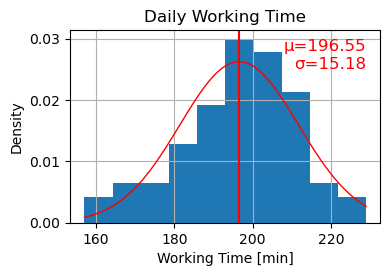

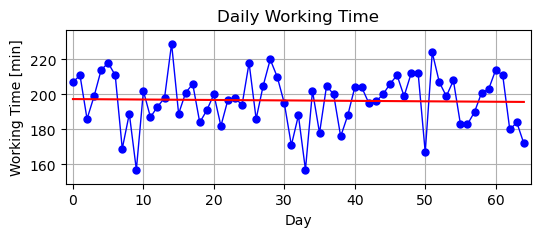

(196.55384615384617, 199.0, 15.300153971070406)

seed 1


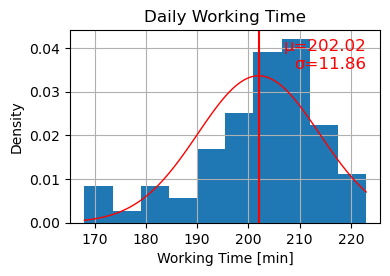

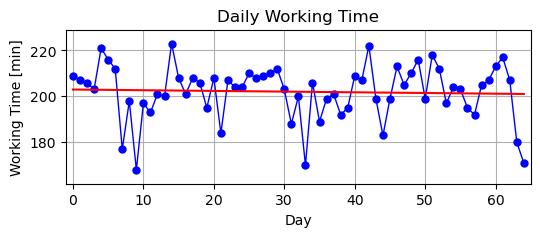

(202.01538461538462, 204.0, 11.954983672736011)

seed 2


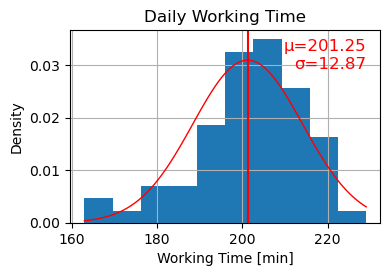

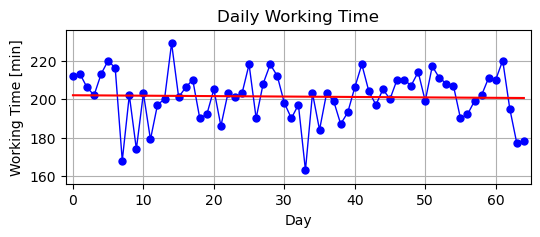

(201.24615384615385, 203.0, 12.966339558196891)

seed 3


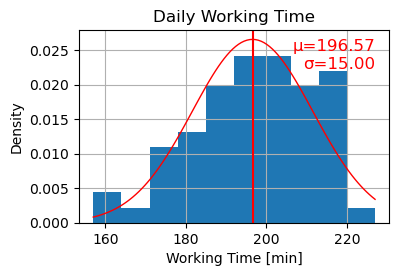

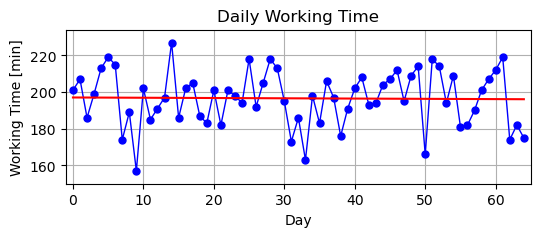

(196.56923076923076, 198.0, 15.115150957285822)

seed 4


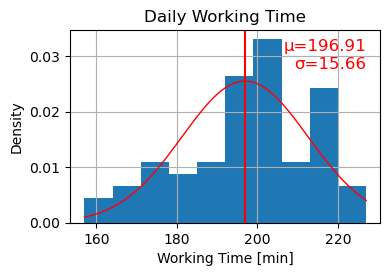

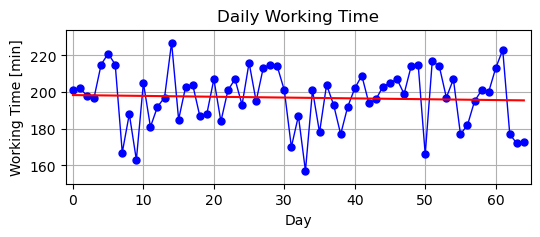

(196.90769230769232, 200.0, 15.780449808349765)



In [100]:
i = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    print(f'seed {i}')
    rec.histWorkingTime()
    rec.plotWorkingTime()
    print(rec.statsWorkingTime())
    #ax.set_xticklabels(["warehouses0", "warehouses1", "warehouses2"]) 
    #ax.set_ylabel("mean") 
    plt.show()
    
    print()
    i += 1

seed 0


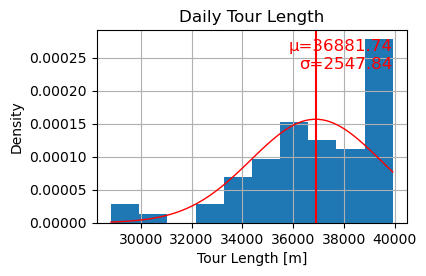

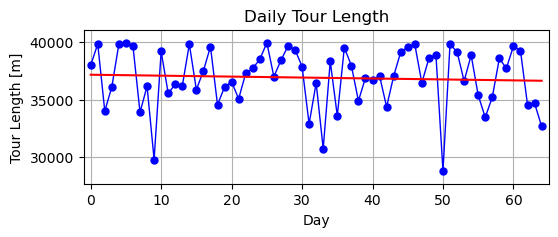

(36881.73846153846, 37038.0, 2567.6725555264725)

seed 1


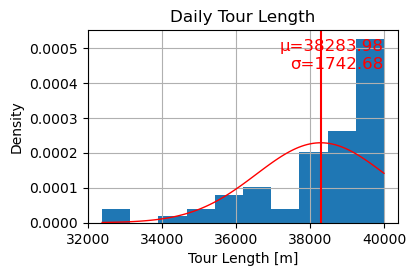

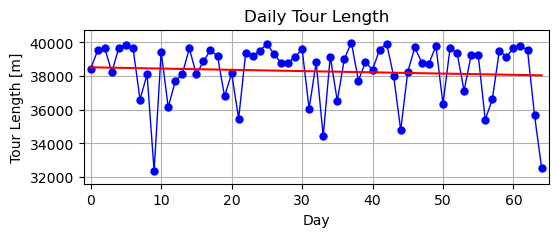

(38283.984615384616, 38874.0, 1756.2373086045677)

seed 2


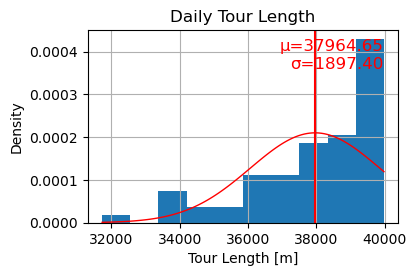

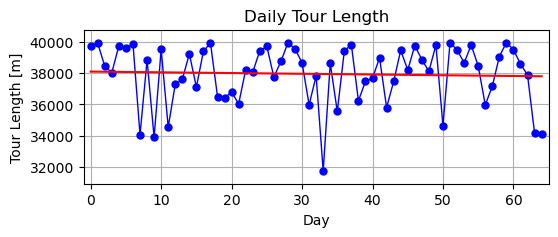

(37964.64615384615, 38486.0, 1912.1687575137134)

seed 3


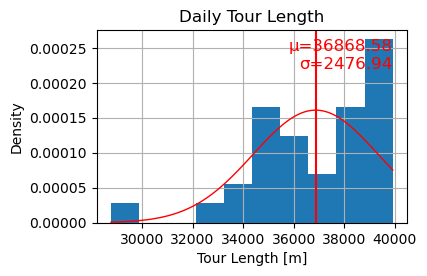

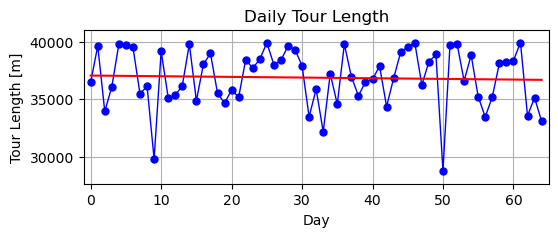

(36868.584615384614, 36956.0, 2496.2171999116217)

seed 4


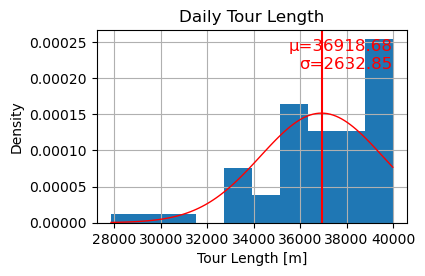

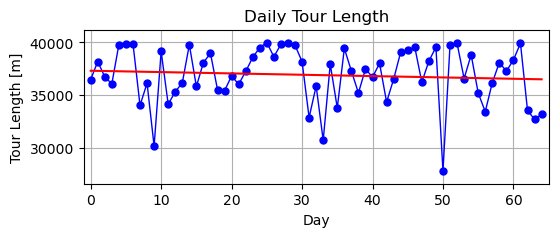

(36918.67692307692, 37282.0, 2653.342627162083)



In [101]:
i = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    print(f'seed {i}')
    rec.histTourLength()
    rec.plotTourLength()
    print(rec.statsTourLength()) 
    plt.show()
    
    print()
    i += 1

seed 0


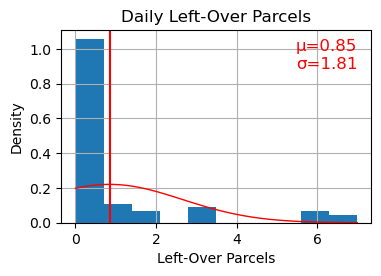

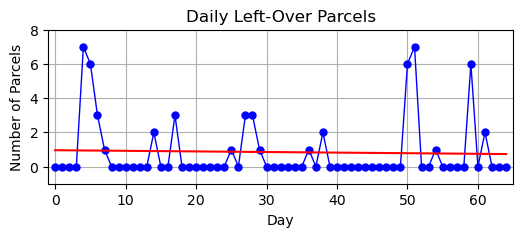

(0.8461538461538461, 0.0, 1.822007557191116)

seed 1


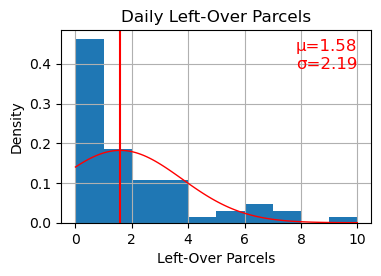

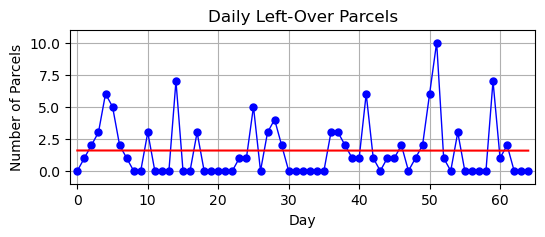

(1.5846153846153845, 1.0, 2.2071779754665495)

seed 2


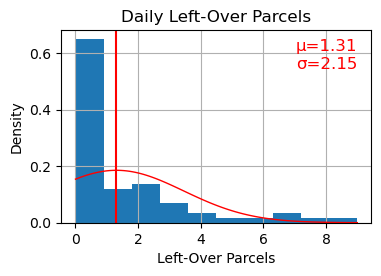

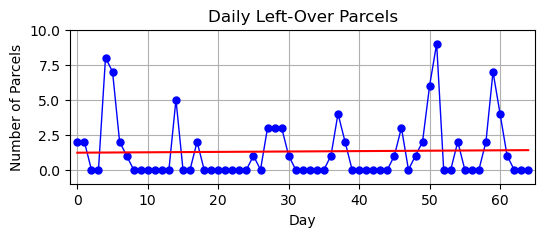

(1.3076923076923077, 0.0, 2.1645082937808655)

seed 3


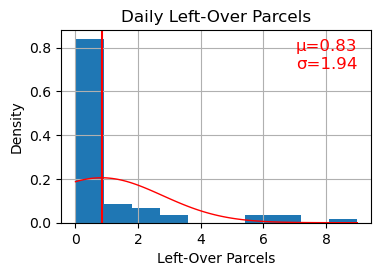

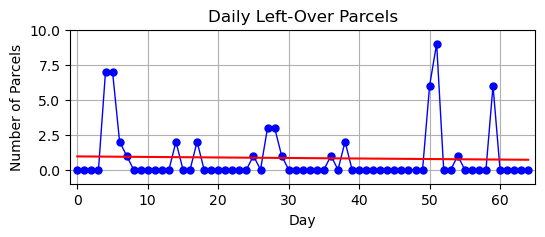

(0.8307692307692308, 0.0, 1.957112276170803)

seed 4


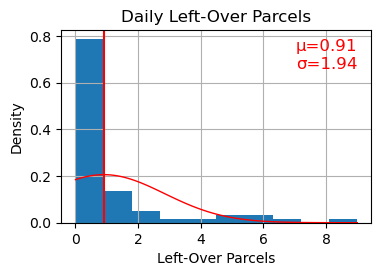

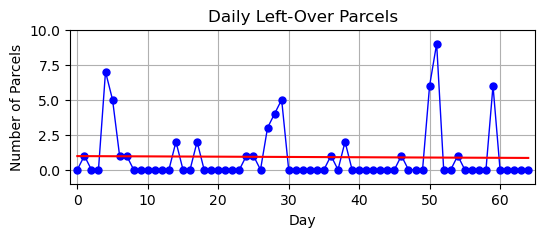

(0.9076923076923077, 0.0, 1.9503451371093665)



In [102]:
i = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    print(f'seed {i}')
    rec.histLeftOver()
    rec.plotLeftOver()
    print(rec.statsLeftOver())
    plt.show()
    
    print()
    i += 1

seed 0


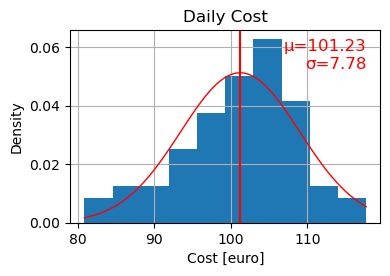

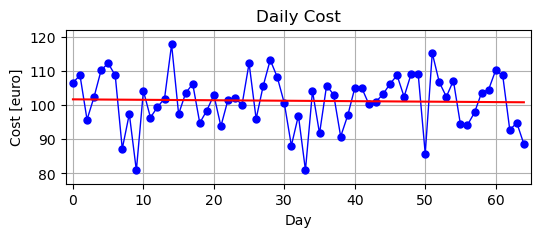

(101.2274621538462, 102.4152, 7.839236138483235)

seed 1


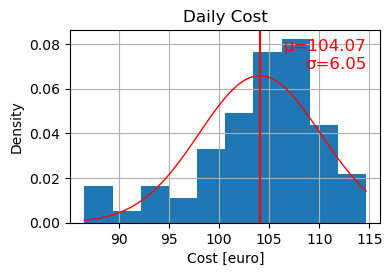

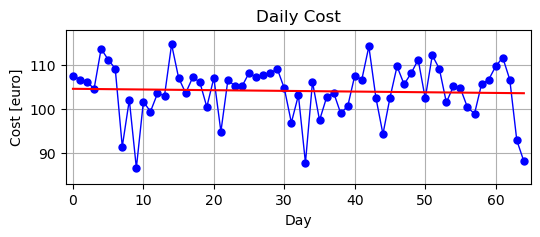

(104.07041107692308, 105.15904, 6.100958522050072)

seed 2


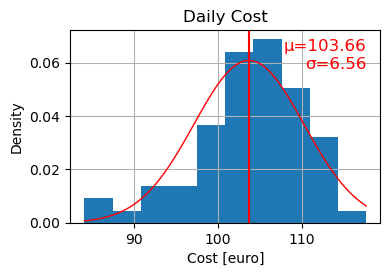

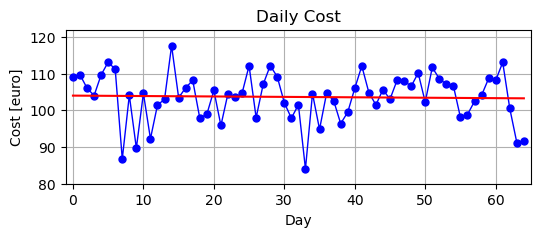

(103.66024861538462, 104.59152, 6.615243635228005)

seed 3


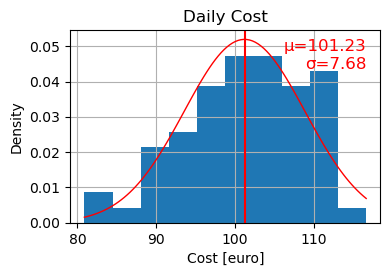

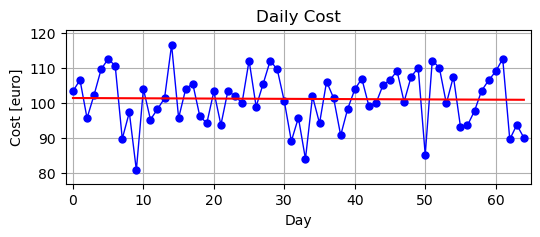

(101.23410215384618, 101.97632, 7.741197121175868)

seed 4


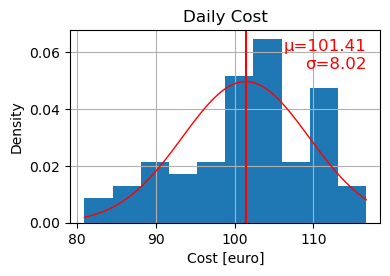

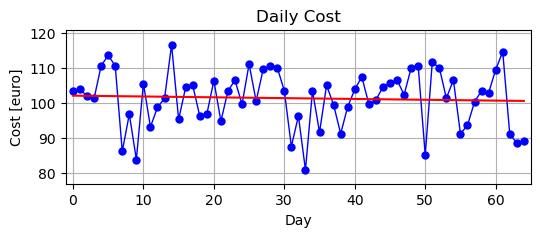

(101.40734030769232, 102.98256, 8.083383516127771)



In [103]:
i = 0
for rec in loadSimulations(total_warehouse,days=No_of_Days):
    print(f'seed {i}')
    rec.histCost()
    rec.plotCost()
    print(rec.statsCost())
    plt.show()
    
    print()
    i += 1

In [104]:
minimum_cost

101.2274621538462

In [105]:
warehouses = []
for rec in loadSimulations(total_warehouse,days=No_of_Days):
#   print(rec.perDayStats())
    warehouse = rec.perDayStats()['cost']
    warehouses.append(list(warehouse))
#warehouses

In [106]:
costs[1]

104.07041107692308

<h2 style="color:darkred">STATISTICAL ANALYSIS</h2>


In [107]:
Image(url="Stat-test-flow.png", width=700, height=600)

<h3 style="color:darkred">Test 1 : SHAPIRO TEST OF NORMALITY </h3>

In this test we will check whether the data is normally distributed   

In [108]:
from scipy.stats import shapiro
shapiro(warehouses)


ShapiroResult(statistic=0.9675418734550476, pvalue=1.1565126669665915e-06)

<h3 style="color:red">Null hypothesis (Ho): The data is Normally Distributed (P-value > 0.05). </h3>

<h3 style="color:red"> Alternate hypothesis (H1): The data is Not Normally Distributed (P-value < 0.05).</h3>
    
Seen the P-value is < 0.05, therefore we reject the Null hypothesis (Ho) of normality and accept the Alternate Hypothesis

<h1 style="color:darkgreen">The above normality distribution test failed to satisfy assumption of ANOVA TEST of been normally distributed</h1>

<h1 style="color:darkgreen">(below ANOVA test can be skipped)</h1>



<h3 style="color:darkred">Test 2 : ANOVA TEST </h3>

In this test we will check whether there is statistically significant difference in the Warehouses Cost   

In [109]:
from scipy.stats import f_oneway
# ANOVA test on mean costs
f_statistic, p_value = stats.f_oneway(*warehouses)
print("ANOVA test on mean costs:")
print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference (alpha=0.05) in mean costs between warehouses.")
else:
    print("There is no statistically significant difference (alpha=0.05) in mean costs between warehouses based on mean data.")

ANOVA test on mean costs:
F-statistic: 2.4480761189314952
p-value: 0.04626366665136071
There is a statistically significant difference (alpha=0.05) in mean costs between warehouses.


<h3 style="color:darkred">Test 3 : KRUSKAL-WALLIS H TEST</h3>

<h3 style="color:darkred">We will use non-parametic method to check the statistical significant difference in the group on data</h3>

In [110]:
from scipy.stats import kruskal
statistic, pvalue = stats.kruskal(*warehouses)
print("Kruskal test on median costs:")
print(f"H-statistic: {statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in median costs between warehouses.")
else:
    print("There is no statistically significant difference in median costs between warehouses based data")


Kruskal test on median costs:
H-statistic: 10.002584482160294
p-value: 0.04626366665136071
There is a statistically significant difference in median costs between warehouses.


<h3 style="color:darkred">The p-value of Kruskal-wallis test is 0.04626 which is less than 0.05, therefore we can conclude there is statistical significant difference in the group on data</h3>

<h3 style="color:darkred">Test 4 : POST HOC TEST</h3>

<h3 style="color:darkred">Using Post-hoc test we can examine statistical significant difference between within each pairs of warehouse location </h3>

In [111]:
import scikit_posthocs as sp
sp.posthoc_ttest(warehouses)

,1,2,3,4,5
1,1.000000,0.022638,0.058092,0.996131,0.897725
2,0.022638,1.000000,0.713880,0.021922,0.035933
3,0.058092,0.713880,1.000000,0.056965,0.084451
4,0.996131,0.021922,0.056965,1.000000,0.900885
5,0.897725,0.035933,0.084451,0.900885,1.000000


<h1 style="color:darkred">VISUALIZATION USING BOX-PLOT</h1>

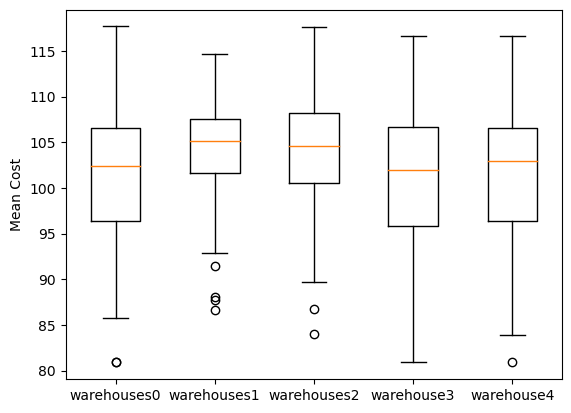

In [112]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([warehouses[0],
                warehouses[1],
                warehouses[2],
                warehouses[3], 
                warehouses[4],
           ])
ax.set_xticklabels(["warehouses0", "warehouses1",
                    "warehouses2", "warehouse3", "warehouse4"]) 
ax.set_ylabel("Mean Cost") 
plt.show()

In [113]:
Total_costs = np.round(Total_costs,2)

<h1 style="color:darkred">GRAPH-PLOT WITH TOTAL COST OF WAREHOUSES</h1>

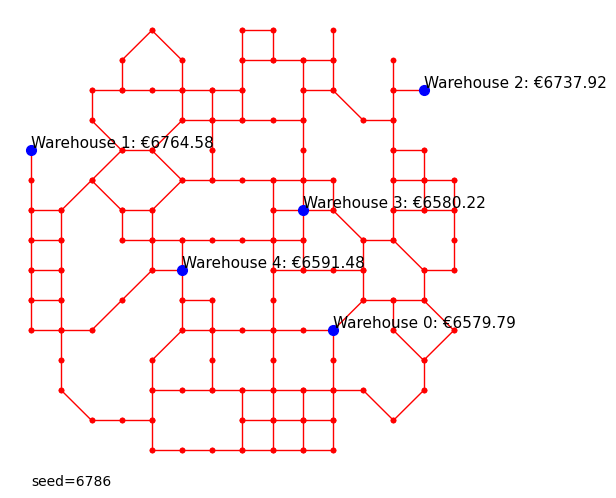

In [114]:
plotMap(M,P=[], mW=total_warehouse, together= True, costs=Total_costs , text="seed=6786")

<h1 style="color:darkred">SIMULATION REPORT SUMMARY:</h1>

In [115]:
data = {"Warehouses":[0,1,2,3,4],"Number of days":No_of_Days, "Locations": total_warehouse, "Mean Cost (€)":costs, "Total Cost (€)": Total_costs, "Mean working time (min)":MeanWorkingTime,"Mean tour length (meter)":MeanTourLength,"Mean Left-over Parcel":MeanLeftOverParcel,"Time (Sec)": totalTime}
Result_Table = pd.DataFrame(data)
Result_Table.set_index("Warehouses")
Result_Table

,Warehouses,Number of days,Locations,Mean Cost (€),Total Cost (€),Mean working time (min),Mean tour length (meter),Mean Left-over Parcel,Time (Sec)
0,0,65,"(5470, 2530)",101.227462,6579.79,196.55,36881.74,0.85,2937.20
1,1,65,"(570, 5470)",104.070411,6764.58,202.02,38283.98,1.58,3596.21
2,2,65,"(6940, 6450)",103.660249,6737.92,201.25,37964.65,1.31,1999.88
3,3,65,"(4980, 4490)",101.234102,6580.22,196.57,36868.58,0.83,2316.12
4,4,65,"(3020, 3510)",101.407340,6591.48,196.91,36918.68,0.91,1725.29


<h1 style="color:darkred">SIMULATION CONCLUSIONS:</h1>

<h3 style="color:darkgreen"> By running Multi-simulation we were successfully in getting minimum cost of warehouse location 
(warehouse 0 as 6579 €) and maximum cost ( warehouse 1 with 6764 €) for number of days 65. After statistical analysis tests the data is observed as significant. therefore, this simulation is accepted.</h3>